In [1]:
import torch
from PIL import Image
import PIL
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torch.nn import functional as f
import clip

from diffusers import StableDiffusionImg2ImgPipeline
from diffusers.utils import (
    PIL_INTERPOLATION,
)
from torchvision.utils import make_grid
import torchvision

In [ ]:
# load stable diffusion pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", revision="fp16", torch_dtype=torch.float16, safety_checker=None
).to(device)

# uncomment this if you have troubles with available memory
# pipe.enable_attention_slicing()

# load CLIP mopdel
model, preprocess = clip.load("ViT-L/14", device=device)


In [ ]:
# utils tp draw images in one grid
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# preprocessing util
def preprocess1(image):
    if isinstance(image, torch.Tensor):
        return image
    elif isinstance(image, PIL.Image.Image):
        image = [image]

    if isinstance(image[0], PIL.Image.Image):
        w, h = image[0].size
        w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
        print(w, h)

        image = [np.array(i.resize((w, h), resample=PIL_INTERPOLATION["lanczos"]))[None, :] for i in image]
        image = np.concatenate(image, axis=0)
        image = np.array(image).astype(np.float32) / 255.0
        image = image.transpose(0, 3, 1, 2)
        image = 2.0 * image - 1.0
        image = torch.from_numpy(image)
    elif isinstance(image[0], torch.Tensor):
        image = torch.cat(image, dim=0)
    return image

In [ ]:
# CLIP classification util
def clip_classify(images, prompts, model):
    
    text_embeddings = model.encode_text(prompts)
    images_embeddings = images

    dots = (images_embeddings @ text_embeddings.T)
    return f.softmax(dots, dim=1)

In [ ]:
# add path to your image
init_image = Image.open('/home/sharfikeg/my_files/oxford_pets/_/Leonberger/2.jpg').resize((448,448), PIL.Image.Resampling.LANCZOS)
init_image_tensor = preprocess1(init_image)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/tmp/ipykernel_426550/279605887.py:3 in <cell line: 3>                                       │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/var/tmp/ipykernel_426550/279605887.py'                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'preprocess1' is not defined

In [ ]:
# enter your classes of interest
classes = [
    'an Abyssinian',
    'an American Bulldog',
    'an American Pit Bull Terrier',
    'a Basset Hound',
    'a Beagle',
    'a Bengal',
    'a Birman',
    'a Bombay',
    'a Boxer',
    'a British Shorthair',
    'a Chihuahua','a Egyptian Mau',
    'an English Cocker Spaniel','an English Setter',
    'a German Shorthaired','a Great Pyrenees',
    'a Havanese','a Japanese Chin',
    'a Keeshond','a Leonberger',
    'a Maine Coon','a Miniature Pinscher',
    'a Newfoundland','a Persian',
    'a Pomeranian','a Pug','a Ragdoll',
    'a Russian Blue','a Saint Bernard',
    'a Samoyed','a Scottish Terrier',
    'a Shiba Inu','a Siamese','a Sphynx',
    'a Staffordshire Bull Terrier','a Wheaten Terrier','a Yorkshire Terrier']

prompts = [
    f'A photo of {representative}, type of pet.' for representative in classes
]

images = pipe(prompt=prompts, image=init_image, strength=0.6, guidance_scale=7.5, num_inference_steps=100, num_images_per_prompt=1).images

/home/sharfikeg/anaconda3/envs/myenv/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:483: FutureWarning: You have passed 37 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/60 [00:00<?, ?it/s]

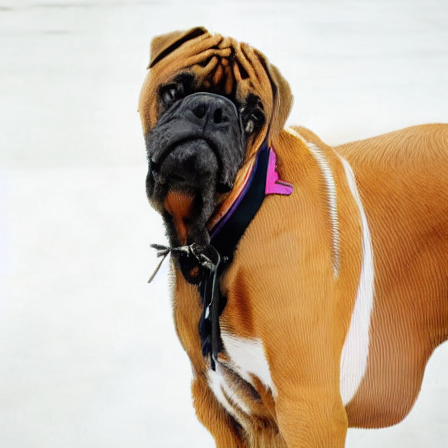

In [ ]:
# you can display ugly creatures here!
images[8]

In [ ]:
# set 'answer' variable to 1 if you want to see the classification results
# set 'answer' variable to 1 if you want to see the generation result
answer = 1
images_tensor_list = [torchvision.transforms.ToTensor()(image) for image in images ]
if answer:
    images_tensor_list_stacked = torch.stack(images_tensor_list, dim=0)
    results = torch.linalg.norm(images_tensor_list_stacked.flatten(start_dim=1, end_dim=-1)-init_image_tensor.flatten(start_dim=1, end_dim=-1), dim=1)

    init_clip = model.encode_image(preprocess(init_image).unsqueeze(0).to(device))
    clip_results = clip_classify(init_clip, prompts=clip.tokenize(prompts).to(device), model=model)

    recons_clip=model.encode_image( torch.stack([preprocess(image) for image in images], dim=0).to(device))
    results = torch.linalg.norm(recons_clip-init_clip, dim=1)
    print(f'clip decision: {classes[torch.argmax(clip_results).item()]}')
    print(f'diffclip decision: {classes[torch.argmin(results).item()]}')
    print(f'top-3: 1: {classes[torch.sort(results)[1][0]]}, 2: {classes[torch.sort(results)[1][1]]}, 3: 2: {classes[torch.sort(results)[1][2]]}\nDiff: {torch.sort(results)[0][1]-torch.sort(results)[0][0]}')
else:
    Grid = make_grid(images_tensor_list[1], nrow=len(classes))

    # display result
    show(Grid)


pred: an Abyssinian
clip decision: a Leonberger
diffclip decision: a Great Pyrenees
top-3: 1: a Great Pyrenees, 2: a Leonberger, 3: 2: a Saint Bernard
Diff: 0.7109375
